# Staging Ground for Training Models

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data

In [3]:
datasets = api.get_genomic_data_availability()
d = db.cache_prep_operation(lambda: feature_data.get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-01-29 10:30:47,587:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


# TPOT Tests

In [5]:
X = d[(src.CCLE_v1, dtyp.GENE_EXPRESSION)]
Y = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)]['NAVITOCLAX']
mask = (X.notnull().any(axis=1)) & (Y.notnull())
X = X[mask]
Y = Y[mask]
X.shape, Y.shape

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


((541, 16042), (541,))

In [6]:
from tpot import TPOTRegressor

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.75, test_size=0.25)

est = Pipeline([
    ('nzv', VarianceThreshold()),
    ('select', SelectKBest(f_regression, k=1000)),
    ('est', TPOTRegressor(generations=5, population_size=20, verbosity=2, max_time_mins=30))
])

est.fit(X_train, y_train)
#print(est.score(X_test, y_test))
#tpot.export('tpot_boston_pipeline.py')

2017-01-29 10:35:31,362:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTP connection (1): updatechecker.bryceboe.com
2017-01-29 10:35:32,027:DEBUG:requests.packages.urllib3.connectionpool: http://updatechecker.bryceboe.com:80 "PUT /check HTTP/1.1" 200 106
Optimization Progress: 100%|██████████| 20/20 [12:52<00:00, 24.20s/pipeline]          

Generation 1 - Current best internal CV score: 1.985001385685587


Optimization Progress:  90%|█████████ | 36/40 [19:38<02:15, 33.78s/pipeline]Optimization Progress:  60%|██████    | 24/40 [13:56<06:13, 23.31s/pipeline]          

Generation 2 - Current best internal CV score: 1.985001385685587


Optimization Progress:  79%|███████▉  | 63/80 [21:41<05:26, 19.21s/pipeline]Optimization Progress:  75%|███████▌  | 45/60 [19:39<04:09, 16.64s/pipeline]Optimization Progress:  92%|█████████▏| 55/60 [19:51<00:20,  4.04s/pipeline]          

Generation 3 - Current best internal CV score: 1.9738314723395334


Optimization Progress:  99%|█████████▉| 79/80 [21:42<00:03,  3.28s/pipeline]Optimization Progress:  86%|████████▋ | 69/80 [21:42<01:43,  9.44s/pipeline]          Optimization Progress:  81%|████████  | 81/100 [21:42<00:43,  2.30s/pipeline]

Generation 4 - Current best internal CV score: 1.9610003013671082


Optimization Progress:  86%|████████▌ | 103/120 [24:02<01:22,  4.86s/pipeline]ptimization Progress:  86%|████████▌ | 86/100 [21:45<00:19,  1.39s/pipeline]          Optimization Progress: 100%|██████████| 100/100 [24:02<00:00,  6.92s/pipeline]

Generation 5 - Current best internal CV score: 1.9610003013671082


Optimization Progress:  99%|█████████▉| 119/120 [28:00<00:11, 12.00s/pipeline]                    

Generation 6 - Current best internal CV score: 1.9479549309893913


                                                                              Optimization Progress:  89%|████████▊ | 124/140 [28:04<01:39,  6.23s/pipeline]Optimization Progress:  93%|█████████▎| 130/140 [28:21<00:30,  3.08s/pipeline]


GP closed prematurely - will use current best pipeline

Best pipeline: ElasticNet(input_matrix, 0.12, 0.70000000000000007)


Pipeline(steps=[('nzv', VarianceThreshold(threshold=0.0)), ('select', SelectKBest(k=1000, score_func=<function f_regression at 0x110e23ae8>)), ('est', TPOTRegressor(crossover_rate=0.05, disable_update_check=False,
       generations=1000000, max_eval_time_mins=5, max_time_mins=30,
       mutation_rate=0.9, num_cv_folds=3, population_size=20,
       random_state=None, scoring=None, verbosity=2))])

In [9]:
tp = est.named_steps['est']

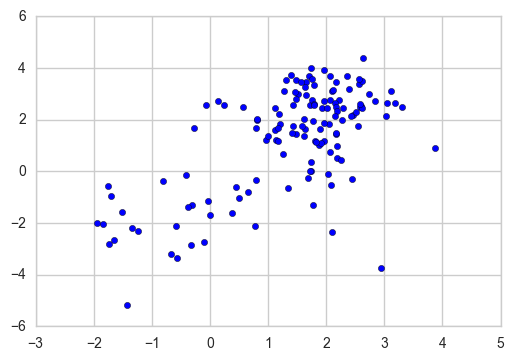

In [14]:
plt.scatter( est.predict(X_test), y_test)

In [22]:
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

params = {
    'C': [.001, .01, .1, 1, 10, 100]
}

# est2 = Pipeline([
#     ('nzv', VarianceThreshold()),
#     ('select', SelectKBest(f_regression, k=1000)),
#     ('est', ElasticNetCV(l1_ratio=.7))
# ])
est2 = Pipeline([
    ('nzv', VarianceThreshold()),
    ('scale', StandardScaler()),
    ('est', GridSearchCV(SVR(), params, cv=5, verbose=11))
])

est2.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] ............................... C=0.001, score=-0.061215 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.029377 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ................................ C=0.001, score=0.000979 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.013899 -   1.9s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV] ............................... C=0.001, score=-0.189350 -   1.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.042775 -   2.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.013830 -   2.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.8s remaining:    0.0s


[CV] ................................. C=0.01, score=0.012060 -   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.000707 -   2.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.8s remaining:    0.0s


[CV] ................................ C=0.01, score=-0.168652 -   2.0s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.8s remaining:    0.0s


[CV] .................................. C=0.1, score=0.068864 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.090128 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.081967 -   2.0s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.103287 -   2.0s
[CV] C=0.1 ...........................................................
[CV] ................................. C=0.1, score=-0.022187 -   2.0s
[CV] C=1 .............................................................
[CV] .................................... C=1, score=0.381552 -   2.0s
[CV] C=1 .............................................................
[CV] .................................... C=1, score=0.330171 -   2.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.0min finished


Pipeline(steps=[('nzv', VarianceThreshold(threshold=0.0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=Tr...01, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=11))])

In [26]:
x = est2.named_steps['est']
x.best_params_

{'C': 10}

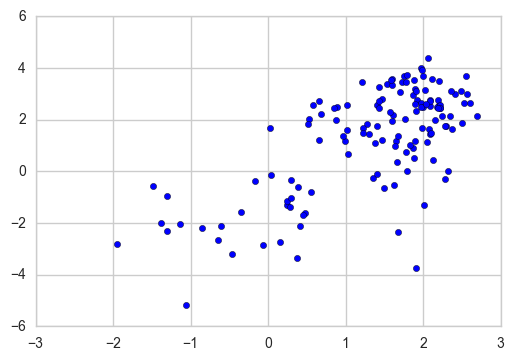

In [23]:
plt.scatter(est2.predict(X_test), y_test)

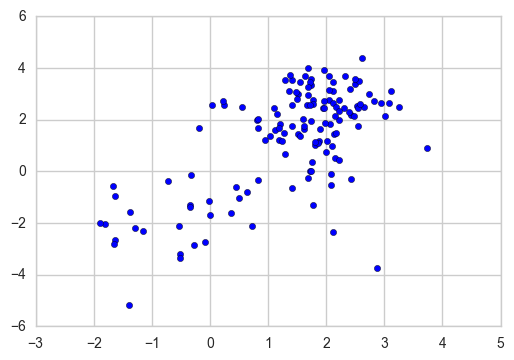

In [17]:
plt.scatter(est2.predict(X_test), y_test)

# Basic Models

In [27]:
# Apoptosis regulation drugs
target_drugs = ['TW37','RTRAIL','EMBELIN','PAC1','OBATOCLAX','YM155','NAVITOCLAX']

In [31]:
X = d[(src.CCLE_v1, dtyp.GENE_EXPRESSION)]
Y = d[(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)][target_drugs]
mask = (X.isnull().mean(axis=1) < .1) & (Y.notnull().any(axis=1))
X = X[mask]
Y = Y[mask]
X.shape, Y.shape

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


((636, 16042), (636, 7))

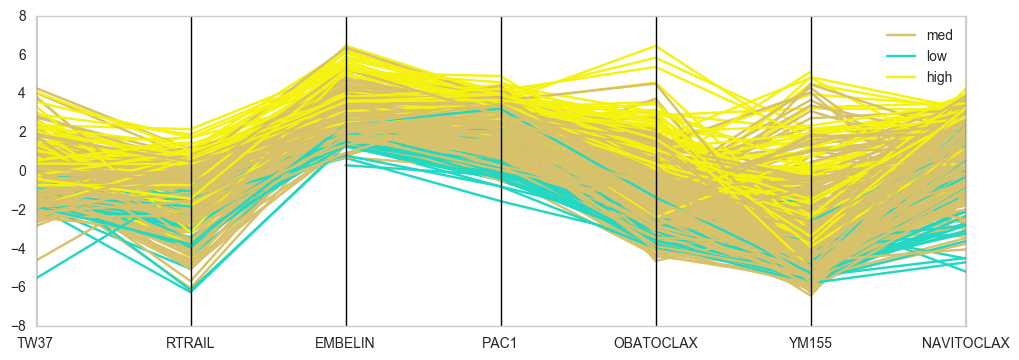

In [46]:
from pandas.tools.plotting import parallel_coordinates
dY = Y.copy()
dY['class'] = pd.cut(dY.mean(axis=1), [-np.inf, -1, 1, np.inf], labels=['low', 'med', 'high'])
plt.figure(figsize=(12,4))
ax = parallel_coordinates(dY, 'class')

In [214]:
from ml.api import trainer as ml_trainer

from ml.sklearn import feature_selection as ml_feature_selection

from mgds.data_modeling.constants import SEED
from sklearn.linear_model import ElasticNet, MultiTaskElasticNet, LassoLarsCV, LassoLarsIC, RandomizedLasso
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from sklearn.grid_search import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from IPython.core.debugger import Tracer

from fancyimpute import MICE, NuclearNormMinimization, KNN, BiScaler

In [108]:
import imp
imp.reload(ml_feature_selection)

<module 'ml.sklearn.feature_selection' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/sklearn/feature_selection.py'>

In [207]:

def get_modeling_results(X, Y, clfs, response_imputer_fn, cv_fn, refit=False):
    
    cv = cv_fn(X, Y)
    
    def data_prep_fn(X_train, X_test, Y_train, Y_test):
        imp = response_imputer_fn()
        Y_train = pd.DataFrame(imp.transform(Y_train), columns=Y_train.columns, index=Y_train.index)
        return X_train, X_test, Y_train, Y_test

    def model_fit_fn(clf_name, clf, X_train, Y_train, X_test, Y_test, fold):
        clf.fit(X_train.values, Y_train.values)

    config = ml_trainer.TrainerConfig(
        data_prep_fn=data_prep_fn,
        model_fit_fn=model_fit_fn,
        keep_test_data=True,
        refit=refit
    )

    trainer = ml_trainer.Trainer()
    return trainer.train_regressors(X, Y, clfs, cv, config=config)

def save_modeling_results(train_res, experiment_num, experiment_name):
    description = rx_train.get_result_description(experiment_name)
    return rx_train.save_training_results(train_res, 'single_source', experiment_num, description)

def get_pipelines(estimators, use_selector=False, use_robust_scaler=False, use_nzv_filter=True):
    clfs = {}
    for name in estimators:
        steps = []
        
        if use_nzv_filter:
            steps.append(('nzv', VarianceThreshold()))
            
        if use_robust_scaler:
            steps.append(('scale', RobustScaler()))
        else:
            steps.append(('scale', StandardScaler()))
            
        if use_selector:
            steps.append(('select', ml_feature_selection.MultiOutputSelect(selector=SelectKBest(f_regression, k=1000), strategy='any')))
            
        steps.append(('clf', estimators[name]))
        clfs[name] = Pipeline(steps)
    return clfs

response_imputer_mean = lambda: FunctionTransformer(lambda X: Imputer(strategy='mean').fit_transform(X), validate=False)
response_imputer_mice = lambda: FunctionTransformer(lambda X: MICE(verbose=False).complete(X.values), validate=False)
response_imputer_knn = lambda: FunctionTransformer(lambda X: KNN(verbose=False, normalizer=BiScaler(verbose=False, center_rows=False, scale_rows=False)).complete(X.values), validate=False)

cv_random = lambda X, Y: KFold(n_splits=10, shuffle=True, random_state=SEED).split(X)
def cv_stratify(X, Y):
    y_class = pd.cut(Y.mean(axis=1), [-np.inf, -1, 1, np.inf])
    assert np.all(y_class.notnull())
    return StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED).split(X, y_class)

In [160]:
#pd.cut(Y.mean(axis=1), [-np.inf, -1, 1, np.inf])

In [226]:
# Standard vs Robust scaling
# Feature selection vs no feature selection
# Stratified vs not
# Multitask vs not
# Impute MICE vs Mean Impute
# Add these 3 as an experiment: LassoLarsCV, LassoLarsIC, RandomizedLasso, Lasso
results = {}

base_clfs = {
    'larsic_st': MultiOutputRegressor(LassoLarsIC(criterion='bic', normalize=True)),
    'larscv_st': MultiOutputRegressor(LassoLarsCV(normalize=True, cv=3, max_n_alphas=30)),
    'enet_st': MultiOutputRegressor(ElasticNet(random_state=SEED, l1_ratio=.7, alpha=.1)),
    'enet_mt': MultiTaskElasticNet(random_state=SEED, l1_ratio=.7, alpha=.1),
    'knn_mt': KNeighborsRegressor(n_neighbors=10, weights='distance', p=2),
    'rf_st': MultiOutputRegressor(RandomForestRegressor(random_state=SEED)),
    'rf_mt': RandomForestRegressor(random_state=SEED),
    'etr_st': MultiOutputRegressor(ExtraTreesRegressor(random_state=SEED)),
    'etr_mt': ExtraTreesRegressor(random_state=SEED),
    'svr_st': MultiOutputRegressor(GridSearchCV(SVR(), {'C': [.1, 1, 10, 50, 100]}, cv=3)),
    'baseline': DummyRegressor()
}

## Experiment 1

In [117]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=Mean:CV=Random'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_random)

2017-01-29 12:44:58,598:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 12:44:59,311:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 12:45:07,082:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 12:45:09,212:INFO:ml.model.log: Running model etr (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 12:45:14,895:INFO:ml.model.log: Running model knn (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 12:45:15,830:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 12:45:29,132:INFO:ml.model.log: Runni

Beginning model refitting


2017-01-29 13:06:50,393:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 0 ==> dim(X_train) = (636, 16042), dim(X_test) = (636, 16042), dim(Y_train) = (636, 7), dim(Y_test) = (636, 7)
2017-01-29 13:06:58,287:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 0 ==> dim(X_train) = (636, 16042), dim(X_test) = (636, 16042), dim(Y_train) = (636, 7), dim(Y_test) = (636, 7)
2017-01-29 13:07:00,580:INFO:ml.model.log: Running model etr (Pipeline) on fold 0 ==> dim(X_train) = (636, 16042), dim(X_test) = (636, 16042), dim(Y_train) = (636, 7), dim(Y_test) = (636, 7)
2017-01-29 13:07:06,932:INFO:ml.model.log: Running model knn (Pipeline) on fold 0 ==> dim(X_train) = (636, 16042), dim(X_test) = (636, 16042), dim(Y_train) = (636, 7), dim(Y_test) = (636, 7)
2017-01-29 13:07:10,083:INFO:ml.model.log: Running model rf (Pipeline) on fold 0 ==> dim(X_train) = (636, 16042), dim(X_test) = (636, 16042), dim(Y_train) = (636, 7), dim(Y_test) = (636, 7)
2017-01-29 13:07:25,982:INFO:ml.model.

In [129]:
save_modeling_results(train_res, 'exp1', experiment_name)

2017-01-29 13:35:30,732:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp1/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp1'

## Experiment 2

In [139]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True, use_robust_scaler=True)
experiment_name = 'Scaler=Robust:Selector=FReg:Impute=Mean:CV=Random'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_random)

2017-01-29 13:43:52,171:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 13:43:53,255:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1739: UserWarning: Objective did not converge, you might want to increase the number of iterations
  warnings.warn('Objective did not converge, you might want'
2017-01-29 13:44:04,439:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 13:44:12,535:INFO:ml.model.log: Running model etr (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572, 7), dim(Y_test) = (64, 7)
2017-01-29 13:44:18,498:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(X_train) = (572, 16042), dim(X_test) = (64, 16042), dim(Y_train) = (572,

In [140]:
save_modeling_results(train_res, 'exp2', experiment_name)

2017-01-29 14:08:41,661:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp2/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp2'

# Experiment 3

- Run this overnight - without a selector its too slow

In [227]:
exp_clfs = {k:v for k, v in base_clfs.items()}
clfs = get_pipelines(exp_clfs, use_selector=False)
experiment_name = 'Scaler=Standard:Selector=None:Impute=MICE:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mice, cv_stratify)

2017-01-29 20:22:12,071:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 20:22:12,342:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:25,199:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:30,395:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:22:51,820:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:25:06,366:INFO:ml.model.log: Running model knn_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 20:25:07,561:INFO:ml.model.

In [232]:
save_modeling_results(train_res, 'exp3', experiment_name)

2017-01-30 06:33:27,405:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp3/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp3'

# Experiment 4

In [171]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=Mean:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mean, cv_stratify)

2017-01-29 14:29:59,694:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 14:30:00,442:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 14:30:08,967:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 14:30:10,992:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 14:30:16,782:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 14:30:49,463:INFO:ml.model.log: Running model knn_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 14:30:50,426:INFO:ml.model.

In [172]:
save_modeling_results(train_res, 'exp4', experiment_name)

2017-01-29 15:11:35,890:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp4/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp4'

## Experiment 5

In [180]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=MICE:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_mice, cv_stratify)

2017-01-29 15:17:43,490:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 15:17:44,225:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 15:17:52,765:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 15:17:54,712:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 15:18:00,458:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 15:18:32,815:INFO:ml.model.log: Running model knn_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 15:18:33,759:INFO:ml.model.

In [185]:
save_modeling_results(train_res, 'exp5', experiment_name)

2017-01-29 16:02:04,541:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp5/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp5'

## Experiment 6

In [208]:
exp_clfs = {k:v for k, v in base_clfs.items() if k != 'knn'}
clfs = get_pipelines(exp_clfs, use_selector=True)
experiment_name = 'Scaler=Standard:Selector=FReg:Impute=KNN:CV=Stratify'
train_res = get_modeling_results(X, Y, clfs, response_imputer_knn, cv_stratify)

2017-01-29 16:55:45,247:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-29 16:55:45,954:INFO:ml.model.log: Running model enet_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 16:55:55,299:INFO:ml.model.log: Running model enet_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 16:55:57,395:INFO:ml.model.log: Running model etr_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 16:56:03,158:INFO:ml.model.log: Running model etr_st (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 16:56:36,929:INFO:ml.model.log: Running model knn_mt (Pipeline) on fold 1 ==> dim(X_train) = (571, 16042), dim(X_test) = (65, 16042), dim(Y_train) = (571, 7), dim(Y_test) = (65, 7)
2017-01-29 16:56:37,889:INFO:ml.model.

In [209]:
save_modeling_results(train_res, 'exp6', experiment_name)

2017-01-29 18:03:51,399:DEBUG:py_utils.io_utils: Serializing object "Training Results" to location "/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp6/results.pkl"


'/Users/eczech/data/research/mgds/modeling/rx/results/single_source/exp6'

# Results Analysis

In [228]:
from ml.api.results import predictions, performance, properties

In [229]:
d_pred = predictions.extract(train_res)

In [230]:
from ml.api.results import performance
from sklearn.metrics import r2_score, mean_squared_error

def score_fn(y_true, y_pred):
    mask = y_true.notnull()
    y_true = y_true[mask.values]
    y_pred = y_pred[mask.values]
    return {
        'r2': r2_score(y_true, y_pred), 
        'mse': mean_squared_error(y_true, y_pred),
        'pearson2': y_true.corr(y_pred, method='pearson')**2,
        'spearman2': y_true.corr(y_pred, method='spearman')**2
    }
d_score = performance.compute_scores(train_res, score_fn, predictions=d_pred)
d_score.head()

Metric              mse                                                     \
Task            EMBELIN NAVITOCLAX OBATOCLAX      PAC1    RTRAIL      TW37   
Model    Fold                                                                
baseline 1     0.684198   3.907166  2.782364  1.087483  1.798434  1.884922   
         2     1.130165   3.956857  2.819118  2.015687  2.191075  1.218058   
         3     1.054757   2.118670  3.122310  1.511005  2.557903  1.367480   
         4     1.148608   4.028397  2.786067  1.424475  1.624586  1.445553   
         5     1.495299   3.534502  2.881066  1.929997  1.353459  1.976616   

Metric                       pearson2                              ...   \
Task              YM155       EMBELIN    NAVITOCLAX     OBATOCLAX  ...    
Model    Fold                                                      ...    
baseline 1     5.180126           NaN           NaN  7.394366e-33  ...    
         2     7.474422           NaN  2.609148e-33           NaN  ...    
         3     4.510568           NaN           NaN           NaN  ...    
         4     4.974230  4.367803e-32  1.286971e-32  5.335594e-33  ...    
         5     6.300115  8.113151e-32  1.145654e-33  2.319934e-32  ...    

Metric               r2                     spearman2                       \
Task             RTRAIL      TW37     YM155   EMBELIN NAVITOCLAX OBATOCLAX   
Model    Fold                                                                
baseline 1    -0.002705 -0.044569 -0.017697       NaN        NaN       NaN   
         2    -0.001580 -0.000305 -0.001260       NaN        NaN       NaN   
         3    -0.009630 -0.001288 -0.019639       NaN        NaN       NaN   
         4    -0.000579 -0.060650 -0.000509       NaN        NaN       NaN   
         5    -0.005189 -0.011591 -0.003054       NaN        NaN       NaN   

Metric                                
Task          PAC1 RTRAIL TW37 YM155  
Model    Fold                         
baseline 1     NaN    NaN  NaN   NaN  
         2     NaN    NaN  NaN   NaN  
         3     NaN    NaN  NaN   NaN  
         4     NaN    NaN  NaN   NaN  
         5     NaN    NaN  NaN   NaN  

[5 rows x 28 columns]

Scaler=Standard:Selector=None:Impute=MICE:CV=Stratify


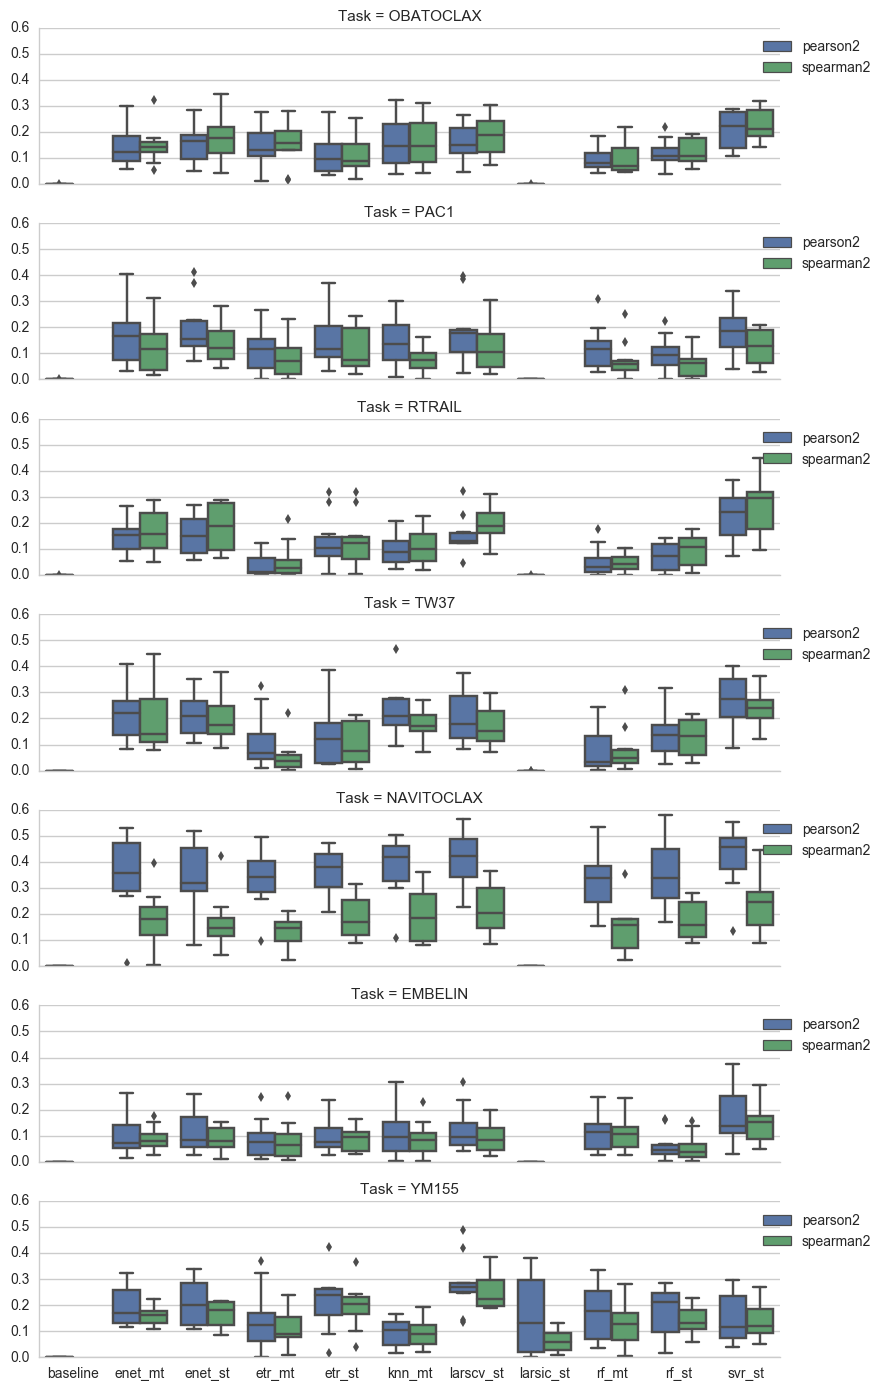

In [231]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
grid, d_viz = performance.plot_scores(
    d_score, metrics=['pearson2', 'spearman2'],
    figaspect=4, legend_margin=(1.14, 1)
)
print(experiment_name)

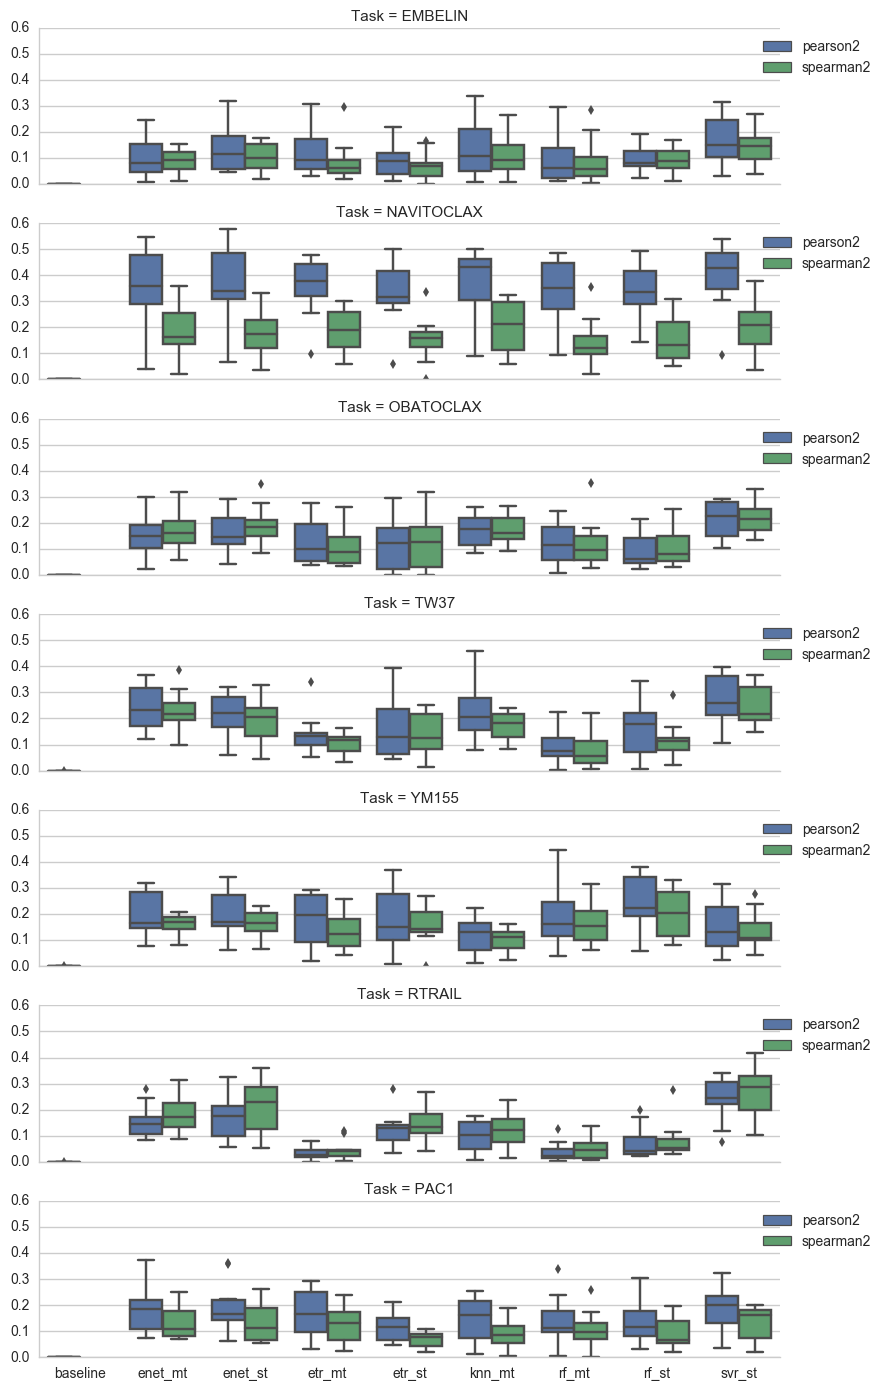

In [184]:
#tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
grid, d_viz = performance.plot_scores(
    d_score, metrics=['pearson2', 'spearman2'],
    figaspect=4, legend_margin=(1.14, 1)
)